в данном файле будет представлен список операции для расшифровки норм из нейросети

## Inputs

In [5]:
import numpy as np
import pandas as pd

import csv
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,5)

from glob import glob
from tqdm import tqdm

## DATA  - данные использованные в обучении на модели xlsx

In [3]:
df = pd.read_excel('./data/3_final/DATA.xlsx')
df.head()

,Unnamed: 0,proj_id,contr_id,0,1,2,3,4,5,6,...,367,368,369,370,371,372,month,year,res_id,target
0,0,15,44,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,7,2021,23,40.0
1,1,15,44,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,11,2021,23,125.0
2,2,15,44,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,11,2021,9,169.5
3,3,15,44,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,12,2021,23,248.6
4,4,15,44,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,12,2021,9,316.4


In [182]:
# старые stages не использовать
# #proj_idc
# proj_ids_dict = np.load('./data/Needed_materials/stages_dict.npy',allow_pickle=True).item()
# proj_ids_dict  = {v:k for k,v in proj_ids_dict.items()}
# df['project_name'] = df.proj_id.map(proj_ids_dict)
# #assert sum(pd.isna(df.project_name)) == 0, 'есть пустые project_name'

In [4]:
# project_ids_names
stages = pd.read_excel('./data/Needed_materials/stages_2022_12_14.xlsx',usecols=[1,2])
proj_ids_dict = stages.set_index('id').project_name.to_dict()
df['project_name'] = df.proj_id.map(proj_ids_dict)
assert sum(pd.isna(df.project_name))==0 , 'пустые проекты'

In [5]:
#res_id
mech_res_dict = np.load( './scripts/3_final/mech_res_dict.npy', allow_pickle=True).item()
c = pd.read_excel('./data/Needed_materials/mech_missed_ids.xlsx',usecols=[0,1],).dropna()
c = c.set_index('missed_name').id.astype( int ).to_dict()
mech_res_dict = {**c,**mech_res_dict}

mech_res_dict_ids = {v:k for k,v in mech_res_dict.items()}
df['resource_name'] = df.res_id.map(mech_res_dict_ids)
assert sum(pd.isna(df.resource_name)) == 0, 'есть пустые машины'

In [6]:
# contr name
feature_contractor_dict = np.load('./scripts/3_final/all_contractors.npy', allow_pickle=True).item()
feature_contractor_dict_ids =  {v:k for k,v in feature_contractor_dict.items()}
df['contractor_name'] = df.contr_id.map(feature_contractor_dict_ids)

new_contractor_dict = {'АО "Стройтранснефтегаз"': 0,
  'ООО "СГК-1"': 1,
  'ООО "ССК "Газрегион"': 2,
  'ООО "Велесстрой"': 3}

df['contr_id'] = df.contractor_name.map(new_contractor_dict)
assert sum(pd.isna(df.contr_id)) == 0, 'есть пустые контракторы'


In [7]:
# plan fact columns
df['Plan'] = np.sum(df.iloc[:,3:-6],axis = 1)
df['Fact'] = df.target

In [8]:
# datetime
df['dt'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + '01'
df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d') )


### научим модель в predict для DATA

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

In [11]:
# класс для слоя с позитивными весами
class positive_weights_linear(nn.Module):
    def __init__(self, in_features, out_features):
        super(positive_weights_linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input_x, res_id):
        
        return torch.matmul( self.weight[res_id.long()].exp() , input_x )
        


In [12]:
# класс с 1 месяцем
class predict_hours_net(nn.Module):
    '''
        всего работ по нормам 373 шт. = "in_features" в слое "activity_dense"
        всего видов техники = 246 (все виды техники берутся из норм PO№№№ ) = "out_features" в слое "activity_dense"
        всего подрядчиков 4 шт. = "in_features" в слое "contractor_dense"
        всего проектов 23 шт. = "in_features" в слое "proj_dense"
    '''

    def __init__(self):
        super(predict_hours_net, self).__init__()
        
        #  out_features = количество техник 246
        self.activity_dense = positive_weights_linear(in_features=373, out_features = 246 ) 
        self.proj_dense = torch.nn.Linear(in_features=23, out_features = 1, bias = False)
        self.contractor_dense = torch.nn.Linear(in_features=4, out_features = 1, bias = False)        
        self.year_dense = torch.nn.Linear(in_features=2, out_features = 1, bias = True)
        self.month_dense = torch.nn.Linear(in_features=12, out_features = 1, bias = False)
        
    def forward(self, x):
        # умножили на матрицу весов
        sum_of_activities = self.activity_dense(x[2:-3],x[-1].long() )
        
        # умножили на коэф месяца
        sum_of_activities_month = self.month_dense.weight[0,x[-3].long()] *  sum_of_activities
        
        # умножили на коэф.года
        sum_of_activities_month_year = self.year_dense.weight[0,x[-2].long() ] *  sum_of_activities_month
        
        # умножили на коэф.контрактора
        predict = self.contractor_dense.weight[0,x[1].long()] * sum_of_activities_month_year
        
        return predict

net = predict_hours_net()
print(net)
torchinfo.summary(net)

predict_hours_net(
  (activity_dense): positive_weights_linear()
  (proj_dense): Linear(in_features=23, out_features=1, bias=False)
  (contractor_dense): Linear(in_features=4, out_features=1, bias=False)
  (year_dense): Linear(in_features=2, out_features=1, bias=True)
  (month_dense): Linear(in_features=12, out_features=1, bias=False)
)


Layer (type:depth-idx)                   Param #
predict_hours_net                        --
├─positive_weights_linear: 1-1           91,758
├─Linear: 1-2                            23
├─Linear: 1-3                            4
├─Linear: 1-4                            3
├─Linear: 1-5                            12
Total params: 91,800
Trainable params: 91,800
Non-trainable params: 0

In [13]:
net_state_dict = torch.load('./weights/log_model_huber_05_epoch_500_loss_69_mae_547.pt')
net.load_state_dict(net_state_dict)


<All keys matched successfully>

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

predict_hours_net(
  (activity_dense): positive_weights_linear()
  (proj_dense): Linear(in_features=23, out_features=1, bias=False)
  (contractor_dense): Linear(in_features=4, out_features=1, bias=False)
  (year_dense): Linear(in_features=2, out_features=1, bias=True)
  (month_dense): Linear(in_features=12, out_features=1, bias=False)
)

In [7]:
df['year'] = df.year - 2021
df['month'] = df.month - 1

NameError: name 'df' is not defined

In [15]:
features = torch.tensor(df.iloc[:,1:-7].values).to(torch.float)
targets = torch.tensor(df.target.values).to(torch.float)
predict = []
net.eval()   # Set model to evaluate mode
for i in range(features.shape[0]):
    with torch.no_grad():
        pred = net(features[i])
        predict.append(pred.tolist())

In [16]:
df['Predict_NN'] = predict

### проверяем метрики МАЕ и выбираем что выгружать

In [17]:
from sklearn.metrics import mean_absolute_error

In [18]:
result = []
for i in pd.unique(df.res_id):
    if len(df.loc[(df.res_id == i) & (df.proj_id==23), 'target']) ==0 : continue
    mae = mean_absolute_error(df.loc[(df.res_id == i) & (df.proj_id==23), 'target'],   df.loc[(df.res_id == i) & (df.proj_id==23),'Predict_NN'] )
    count = len(df.loc[(df.res_id == i) & (df.proj_id==23),:])
    result.append({'res_id':i, 'res_name':mech_res_dict_ids[i],'model_MAE':mae,'count':count})

In [19]:
list(zip(pd.unique(df.proj_id),list(map(proj_ids_dict.get,pd.unique(df.proj_id)))))

[(15, 'КС-1 Салдыкельская Сила Сибири Этап 5.1'),
 (23, 'КС-2 Олекминская Сила Сибири Этап 5.2'),
 (16, 'КС-2 Олекминская Сила Сибири Этап 6.2'),
 (17, 'КС-3 Амгинская Сила Сибири Этап 5.3'),
 (18, 'КС-4 Нимнырская Сила Сибири Этап 6.4'),
 (19, 'КС-5 Нагорная Сила Сибири Этап 5.5'),
 (20, 'КС-6 Сковородинская Сила Сибири Этап 5.6'),
 (21, 'КС-6 Сковородинская Сила Сибири Этап 6.6'),
 (22, 'КС-7 Сивакинская Сила Сибири Этап 5.7')]

In [20]:
df.sort_values(by='dt',inplace=True)

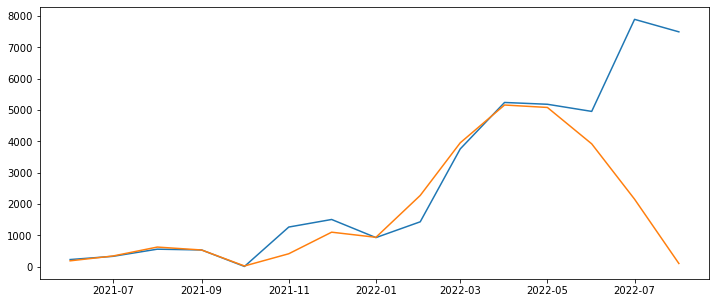

In [39]:
def plot(i,proj):
#     i = 30
#     proj = 23
    plt.plot(df.loc[(df.res_id==i) & (df.proj_id == proj),'dt'], df.loc[(df.res_id == i) & (df.proj_id==proj), 'target'])
    plt.plot(df.loc[(df.res_id==i) & (df.proj_id == proj),'dt'], df.loc[(df.res_id == i) & (df.proj_id==proj),'Predict_NN'])
plot(30,17)


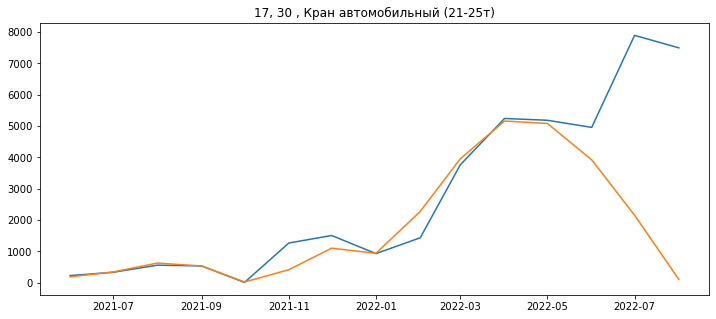

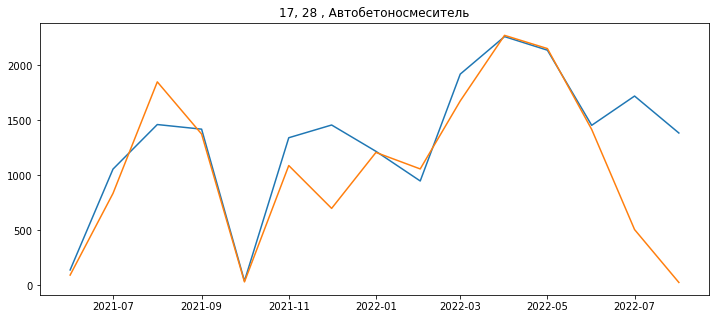

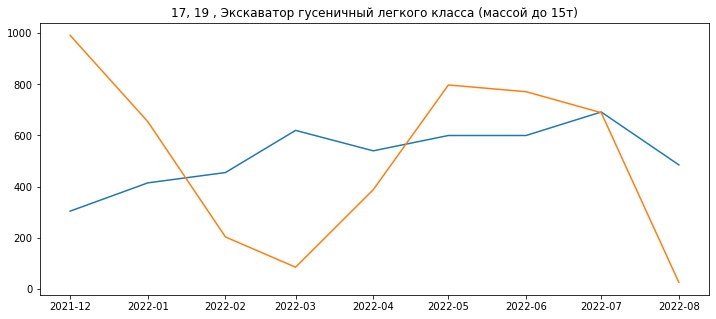

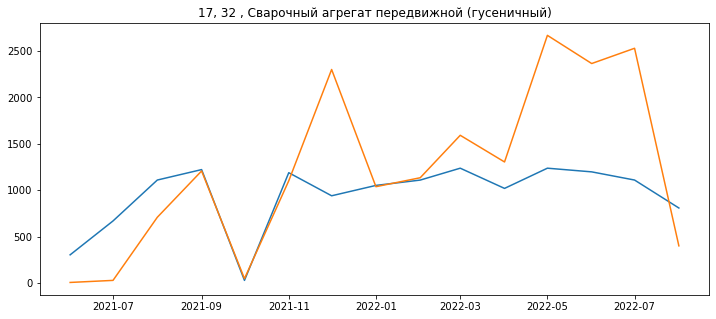

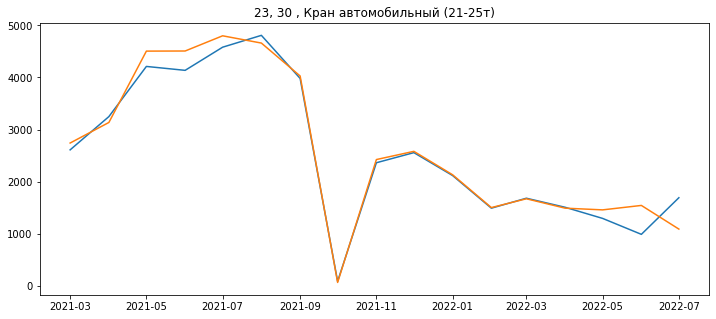

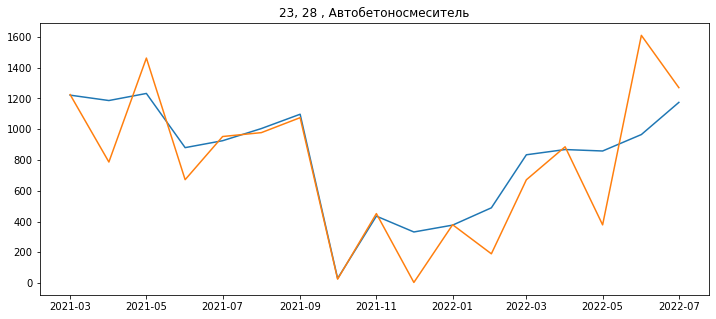

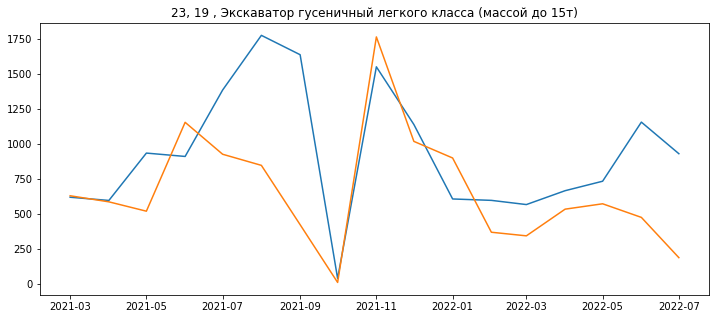

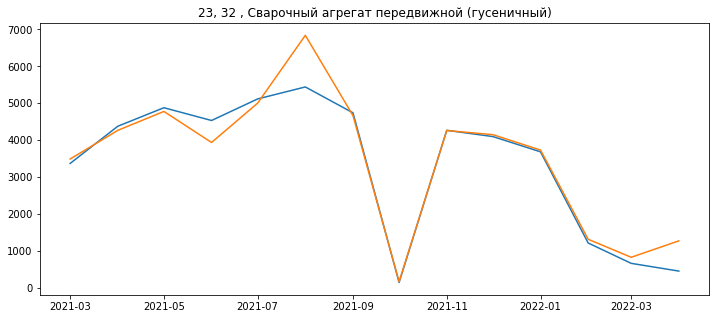

In [40]:
# to be used for publication
id = [30, 28,19,32 ] #,112,48
for p in [17,23]:
    for l in id:
        plt.title(f'{p}, {l} , {mech_res_dict_ids.get(l)}')
        plot(l,p)
        plt.show()
    

### Выгружаем в template (top_left)

In [21]:
# Итого 
# на данный момент будут выгружаться id машин 
mech_id = [30, 28,19,32 ] 
# по следующим проектам 
projects_id= [17,23]


In [116]:
list(map(lambda x : x in mech_id, df['res_id']  ))

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

In [22]:
# фильтруем по проекту
df_new = df.loc[ list(map(lambda x : x in projects_id, df['proj_id']  ))   ,:]
df_new = df_new.loc[ list(map(lambda x : x in mech_id, df_new['res_id']  ))  ,:]


In [23]:
df_new = df_new.loc[:,['proj_id','project_name','res_id','resource_name', 'contr_id', 'contractor_name','dt','Plan','Fact','Predict_NN']]

df_new.columns = ['project_id','project_name','resource_id','resource_name','contractor_id','contractor_name','dt','Plan','Fact','Predict_NN']
df_new.to_excel('./data/4_to_export/filled_template.xlsx', index=False,sheet_name = 'top_left')
df_new             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,dt,Plan,Fact,Predict_NN
22,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",2021-03-01,15064.347697,2612.04,2743.156494
23,23,КС-2 Олекминская Сила Сибири Этап 5.2,32,Сварочный агрегат передвижной (гусеничный),1,"ООО ""СГК-1""",2021-03-01,4045.658071,3366.01,3485.977051
24,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2021-03-01,649.886509,620.00,630.373718
20,23,КС-2 Олекминская Сила Сибири Этап 5.2,28,Автобетоносмеситель,1,"ООО ""СГК-1""",2021-03-01,8131.646914,1221.00,1224.605469
44,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",2021-04-01,1605.987568,3250.05,3137.526611
...,...,...,...,...,...,...,...,...,...,...
586,17,КС-3 Амгинская Сила Сибири Этап 5.3,28,Автобетоносмеситель,1,"ООО ""СГК-1""",2022-07-01,528.680561,1721.00,507.246307
459,17,КС-3 Амгинская Сила Сибири Этап 5.3,28,Автобетоносмеситель,1,"ООО ""СГК-1""",2022-08-01,59.481421,1385.00,26.630539
457,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2022-08-01,17.438728,485.00,24.923759
448,17,КС-3 Амгинская Сила Сибири Этап 5.3,32,Сварочный агрегат передвижной (гусеничный),1,"ООО ""СГК-1""",2022-08-01,101.826081,809.10,401.715057


### predict на будущих данных - 2023 год. Для Top Left и Bottom Left

#### Загружаем и обрабатываем сырые данные из Primavera

In [7]:
#res_id
mech_res_dict = np.load( './scripts/3_final/mech_res_dict.npy', allow_pickle=True).item()
c = pd.read_excel('./data/Needed_materials/mech_missed_ids.xlsx',usecols=[0,1],).dropna()
c = c.set_index('missed_name').id.astype( int ).to_dict()
mech_res_dict = {**c,**mech_res_dict}


In [12]:
df = pd.read_excel('./data/4_to_export/predict_template_top_left/KS_2.xlsx',
                   usecols= ['PO_id','dt', 'resource_name', 'id_resource', 'remain_qty'])


a = np.zeros((len(df),378))

# КС-2 = 23 , КС-3 = 17
a[:,0] = 23

#res_id
df['res_id'] = df.resource_name.map(mech_res_dict)
assert sum(pd.isna(df.res_id)) == 0, 'есть пустые машины'

#contr_id = 1 (СГК)
a[:,1] = 1 

# month year
from datetime import datetime 
df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.000'))
df['month'] = df.dt.dt.month
df['year'] = df.dt.dt.year - 2021


for j,i in enumerate(df.groupby(['res_id','year','month','PO_id'])):
    # заполняем year month res 
    a[j,-1] = i[0][0]
    a[j,-2] = i[0][1]
    a[j,-3] = i[0][2]
    # PO number
    po_number = int( str(i[0][-1])[2:] )
    a[j,po_number+1] = i[1].remain_qty.sum()

    #if j == 5:break
    
print(j)
a = a[:j]
print('Done. a shape = ', a.shape )   
a = a[np.sum(a[:,2:374],axis=1) > 0.1 ]
print('Non zero shape = ',a.shape)

# заполняем features
feat = np.zeros([1,378])

feat = np.concatenate((feat,a))

feat = feat[1:]

1774
Done. a shape =  (1774, 378)
Non zero shape =  (1719, 378)


In [18]:
df = pd.read_excel('./data/4_to_export/predict_template_top_left/Этап_5_3_Компрессорная_станция_КС_3_«Амгинская» (2).xlsx',
                   usecols= ['PO_id','dt', 'resource_name', 'id_resource', 'act_reg_qty'])


a = np.zeros((len(df),378))

# КС-2 = 23 , КС-3 = 17
a[:,0] = 17

#res_id
df['res_id'] = df.resource_name.map(mech_res_dict)
assert sum(pd.isna(df.res_id)) == 0, 'есть пустые машины'

#contr_id = 1 (СГК)
a[:,1] = 1 

# month year
from datetime import datetime 
df['month'] = df.dt.dt.month
df['year'] = df.dt.dt.year - 2021


for j,i in enumerate(df.groupby(['res_id','year','month','PO_id'])):
    #print(j)
    #print(i[0])
    a[j,-1] = i[0][0]
    a[j,-2] = i[0][1]
    a[j,-3] = i[0][2]
    # PO number
    po_number = int( str(i[0][-1])[2:] )
    a[j,po_number+1] = i[1].act_reg_qty.sum()

    
print(j)
a = a[:j]
print('Done. a shape = ', a.shape )    
a = a[np.sum(a[:,2:374],axis=1) > 0.1 ]
print('Non zero shape = ',a.shape)

# заполняем features
feat = np.concatenate((feat,a))



feat.shape

5650
Done. a shape =  (5650, 378)
Non zero shape =  (3013, 378)


(4732, 378)

In [13]:
 #проверка чтобы в каждом ряду было одно значение
np.count_nonzero(np.sum(feat[:,2:374],axis=1))

1719

In [19]:
 #проверка чтобы в каждом ряду было одно значение
np.count_nonzero(np.sum(feat[:,2:374],axis=1))

4732

In [20]:
# проверка количество PO в каждом ряду только одно
sum(np.count_nonzero(feat[:,2:374],axis=1) > 1)

0

In [24]:
#save 
np.save('./data/4_to_export/predict_template_top_left/feat.npy',feat,allow_pickle=True)

#### добавляем 
- предикт только по новым данным и
- проверить предикт по зимним месяцам

In [23]:
df_new  = pd.read_excel('./data/4_to_export/filled_template.xlsx')
min(df_new.dt), max(df_new.dt)

(Timestamp('2021-03-01 00:00:00'), Timestamp('2022-08-01 00:00:00'))

значит делаем предикт по следующему за 08 месяцем - то бишь предикт все, что дальше сентября

In [6]:
#load 
feat = np.load('./data/4_to_export/predict_template_top_left/feat.npy',allow_pickle=True)

In [7]:
# все что в 2022 годы после 8 месяца и весь 2023 год
features_numpy = feat[(feat[:,-2]==1) & (feat[:,-3]>8) | (feat[:,-2]==2) ]
features_numpy.shape

(4061, 378)

In [8]:
# получаем предикт только по указанным в "ids" машинам
ids = [30, 28,19,32 ]

features_numpy = features_numpy[np.array([True if i in ids else False for i in features_numpy[:,-1]]) ]

features_numpy.shape

(732, 378)

In [23]:
pd.unique(features_numpy[features_numpy[:,0]==23,-1])

array([19., 28., 30., 32.])

#### Bottom Left Predict на 2023 год 
Так как данные в примавере хранятся в виде Bottom Left, то начинаем строить предикт с него.  

графика СНИЗУ СЛЕВА

In [ ]:
# predict для каждой PO по отдельности - то  есть для графика СНИЗУ СЛЕВА

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

predict_hours_net(
  (activity_dense): positive_weights_linear()
  (proj_dense): Linear(in_features=23, out_features=1, bias=False)
  (contractor_dense): Linear(in_features=4, out_features=1, bias=False)
  (year_dense): Linear(in_features=2, out_features=1, bias=True)
  (month_dense): Linear(in_features=12, out_features=1, bias=False)
)

In [50]:
# функция предикта
def predit_torch(ft):
    pd = []
    ft_torch = torch.from_numpy(ft).to(torch.float)
    net.eval()   # Set model to evaluate mode
    for i in range(ft_torch.shape[0]):
        with torch.no_grad():
            pred = net(ft_torch[i])
            pd.append(pred.tolist())
    
    return pd

print('features length 2022+2023 year = ', features_numpy.shape[0])


# сортируем массив - Обязательно
features_numpy = features_numpy[features_numpy[:,-2].argsort()]
the_first_2023_year = np.where(features_numpy[:,-2]==2)[0][0]

predict = []

# changing month
features_numpy[:,-3] = features_numpy[:,-3] -1

# сначала делаем предикт на 2022 году
the_2022_year_last_pos = np.where(features_numpy[:,-2]==2)[0][0]
predict = predit_torch(features_numpy[:the_2022_year_last_pos])
print('predict length 2022 year = ', len(predict))

 # потом делаем предикт на 2023 год
## меняем 2023 год на 2022 чтобы использовать веса 2022 года - так как нет весов 2023 года
features_numpy[the_2022_year_last_pos:,-2]=1 
predict.extend( predit_torch( features_numpy[the_2022_year_last_pos:] ) )
## возвращаем 2023 год 
features_numpy[the_2022_year_last_pos:,-2] =2
print('predict length 2022+2023 year = ', len(predict))

# resuming month
features_numpy[:,-3] = features_numpy[:,-3] +1

features length 2022+2023 year =  732
predict length 2022 year =  298
predict length 2022+2023 year =  732


In [22]:
df = pd.DataFrame(features_numpy[:,:2], columns=['proj_id','contr_id'],dtype=int)

df['res_id'] = features_numpy[:,-1].astype( int )
df['month'] = features_numpy[:,-3].astype( int ) + 1
df['year'] = features_numpy[:,-2].astype( int ) + 2021

df['dt'] = df['year'].astype(str) + '-' + df['month'].astype(str)+ '-01'

df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

non_zero_pos = np.nonzero(features_numpy[:,2:375])[1]+2
df['PO_id'] = non_zero_pos

df['Predict_NN'] = predict

df['Fact'] = features_numpy[np.nonzero(features_numpy[:,2:375])[0],non_zero_pos ]

In [53]:
df.to_excel('./data/4_to_export/predict_template_top_left/bottom_left.xlsx')

In [67]:
# project_ids_names
stages = pd.read_excel('./data/Needed_materials/stages_2022_12_14.xlsx',usecols=[1,2])
proj_ids_dict = stages.set_index('id').project_name.to_dict()
df['project_name'] = df.proj_id.map(proj_ids_dict)
assert sum(pd.isna(df.project_name))==0 , 'пустые проекты'

In [68]:
#res_id
mech_res_dict = np.load( './scripts/3_final/mech_res_dict.npy', allow_pickle=True).item()
c = pd.read_excel('./data/Needed_materials/mech_missed_ids.xlsx',usecols=[0,1],).dropna()
c = c.set_index('missed_name').id.astype( int ).to_dict()
mech_res_dict = {**c,**mech_res_dict}

mech_res_dict_ids = {v:k for k,v in mech_res_dict.items()}
df['resource_name'] = df.res_id.map(mech_res_dict_ids)
assert sum(pd.isna(df.resource_name)) == 0, 'есть пустые машины'

In [87]:
# contr name
new_contractor_dict = {'АО "Стройтранснефтегаз"': 0,
  'ООО "СГК-1"': 1,
  'ООО "ССК "Газрегион"': 2,
  'ООО "Велесстрой"': 3}

new_contractor_dict_ids = {v:k for k,v in new_contractor_dict.items()}

df['contractor_name'] = df.contr_id.map(new_contractor_dict_ids)
assert sum(pd.isna(df.contr_id)) == 0, 'есть пустые контракторы'


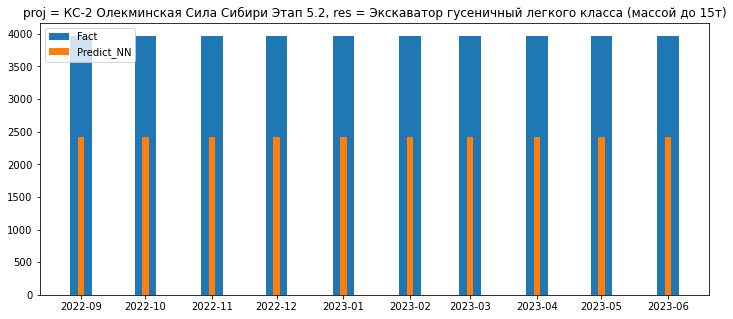

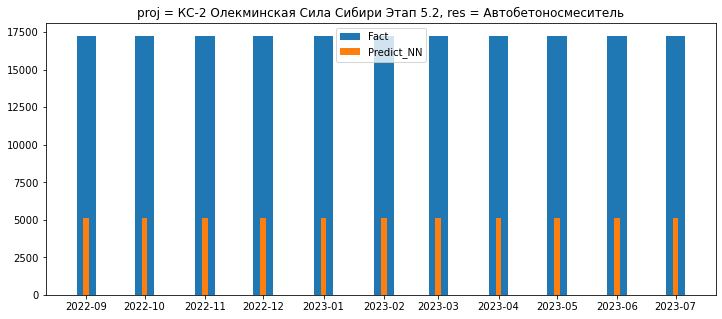

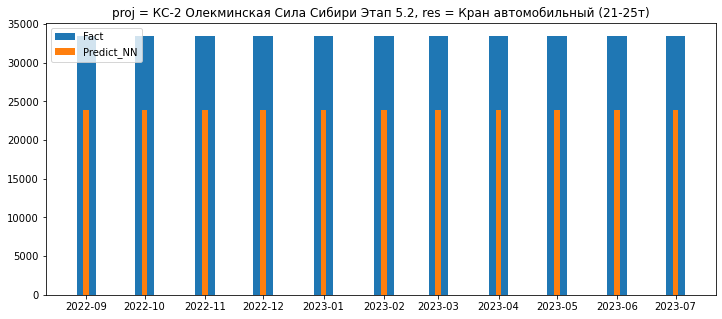

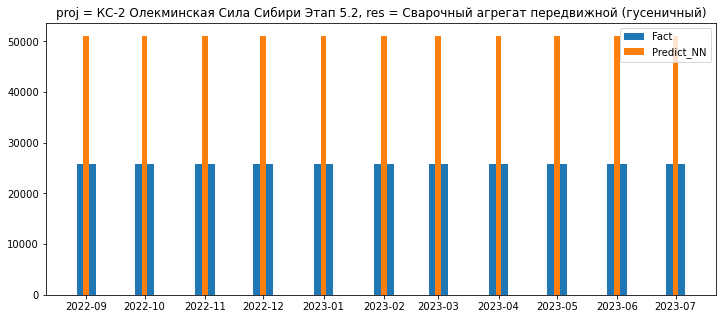

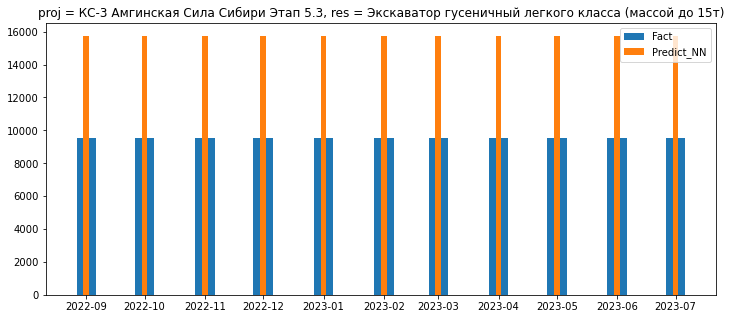

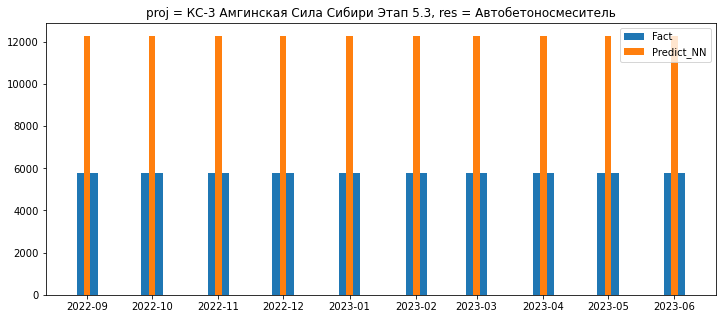

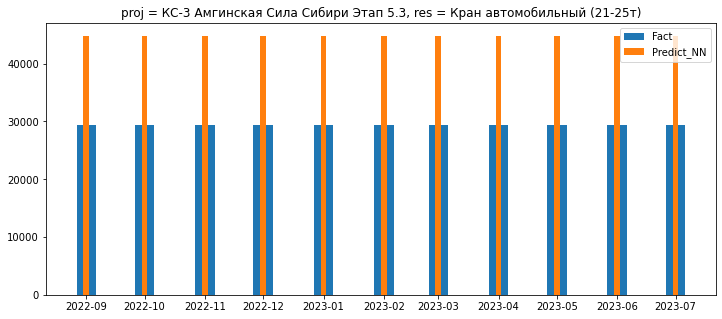

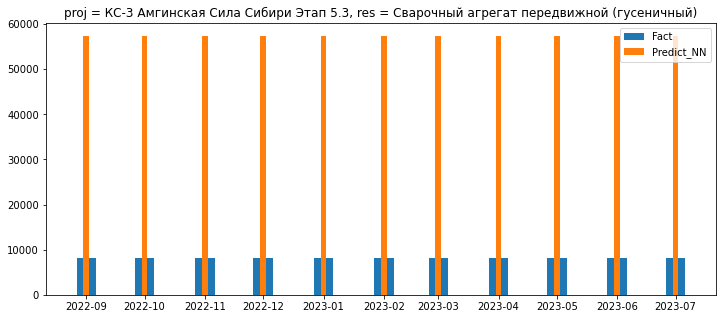

In [90]:
# проверка графиков
for p in pd.unique(df.proj_id):
    for r in pd.unique(df.res_id):
        a = df.loc[(df.proj_id==p) & (df.res_id==r)]
        plt.title(f'proj = {proj_ids_dict[p]}, res = {mech_res_dict_ids.get(r)}')
        plt.bar(a.dt, a.Fact.sum(),label='Fact',width= 10)
        plt.bar(a.dt, a.Predict_NN.sum(),label='Predict_NN',width=3)
        plt.legend(loc='best');
        plt.show()
        

####  Bottom Left  Выгружаем (создаем PO_name)

In [97]:
# PO создаем
norms_ids_dict = np.load('./data/Needed_materials/Norms_ids_dict.npy', allow_pickle=True).item()
l = [ int(str(k)[2:]) if str(k)[2:].isnumeric() else str(k)[2:] for k in norms_ids_dict.keys()]
norms_dict = dict(zip(l,norms_ids_dict.values()))
df['PO_name'] = df.PO_id.map(norms_dict)

In [100]:
# объединяем и выгружаем
df_pred = df.loc[:,['proj_id','project_name','res_id','resource_name', 'contr_id', 'contractor_name','PO_id','PO_name','dt','Fact','Predict_NN']]

df_pred.columns = ['project_id','project_name','resource_id','resource_name','contractor_id','contractor_name','PO_id','PO_name','dt','Fact','Predict_NN']
df_pred.to_excel('./data/4_to_export/filled_template_bottom_left_predict_2023.xlsx', index=False,sheet_name = 'bottom_left')
df_pred.head()             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,PO_id,PO_name,dt,Fact,Predict_NN
0,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",28,"Монтаж м/к (лестницы, площадки обслуживания)",2022-09-01,12.372202,5.554081
1,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",29,АКЗ м/к,2022-09-01,47.207387,79.967346
2,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",282,Монтаж ограждения площадки (Dfence Prof) (мета...,2022-10-01,25.305363,7.747723
3,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",298,Изготовление и монтаж дренажного колодца (Ду17...,2022-11-01,261.444187,660.366211
4,23,КС-2 Олекминская Сила Сибири Этап 5.2,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",32,Монтаж ограждающих конструкций (стеновые и кро...,2022-11-01,124.242000,64.837410


In [101]:
# сохраняем result так как он понадобится для графика Bottom_right
df.to_excel('./data/4_to_export/df_predict_2023.xlsx', index=False)

#### Top Left   на 2023 год (обрабатываем Bottom Left предикт на 2023 год )

In [118]:
res = []

for i in df.groupby(['proj_id','res_id','year','month']):
    #print(i[0])
    res.append({'proj_id':i[0][0] ,'res_id':i[0][1] ,
                'year':i[0][2] ,'month':i[0][3], 
                'Predict_NN_sum_PO': i[1].Predict_NN.sum(), 'Fact': i[1].Fact.sum() } )
    #break

print('Done')

Done


In [123]:
df_for_top_left = pd.DataFrame(res)
df_for_top_left['contr_id'] = 1

In [124]:
df_for_top_left.head()

,proj_id,res_id,year,month,Predict_NN_sum_PO,Fact,contr_id
0,17,19,2022,9,886.423621,1771.532005,1
1,17,19,2022,10,501.313202,125.149163,1
2,17,19,2022,11,2384.273880,1689.532856,1
3,17,19,2022,12,915.022544,443.139554,1
4,17,19,2023,1,776.750786,211.679427,1


In [125]:
# project_ids_names
stages = pd.read_excel('./data/Needed_materials/stages_2022_12_14.xlsx',usecols=[1,2])
proj_ids_dict = stages.set_index('id').project_name.to_dict()
df_for_top_left['project_name'] = df_for_top_left.proj_id.map(proj_ids_dict)
assert sum(pd.isna(df_for_top_left.project_name))==0 , 'пустые проекты'

In [126]:
#res_id
mech_res_dict = np.load( './scripts/3_final/mech_res_dict.npy', allow_pickle=True).item()
c = pd.read_excel('./data/Needed_materials/mech_missed_ids.xlsx',usecols=[0,1],).dropna()
c = c.set_index('missed_name').id.astype( int ).to_dict()
mech_res_dict = {**c,**mech_res_dict}

mech_res_dict_ids = {v:k for k,v in mech_res_dict.items()}
df_for_top_left['resource_name'] = df_for_top_left.res_id.map(mech_res_dict_ids)
assert sum(pd.isna(df_for_top_left.resource_name)) == 0, 'есть пустые машины'

In [127]:
# contr name
new_contractor_dict = {'АО "Стройтранснефтегаз"': 0,
  'ООО "СГК-1"': 1,
  'ООО "ССК "Газрегион"': 2,
  'ООО "Велесстрой"': 3}

new_contractor_dict_ids = {v:k for k,v in new_contractor_dict.items()}

df_for_top_left['contractor_name'] = df_for_top_left.contr_id.map(new_contractor_dict_ids)
assert sum(pd.isna(df_for_top_left.contr_id)) == 0, 'есть пустые контракторы'


In [132]:
df_for_top_left.columns

Index(['proj_id', 'res_id', 'year', 'month', 'Predict_NN_sum_PO', 'Fact',
       'contr_id', 'project_name', 'resource_name', 'contractor_name'],
      dtype='object')

In [135]:
df_for_top_left['dt'] = df_for_top_left['year'].astype(str) + '-' + df_for_top_left['month'].astype(str)+ '-01'

df_for_top_left['dt'] = df_for_top_left.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

In [136]:
# объединяем и выгружаем
df_for_top_left_pred = df_for_top_left.loc[:,['proj_id','project_name','res_id','resource_name', 'contr_id', 'contractor_name','dt','Fact','Predict_NN_sum_PO']]

df_for_top_left_pred.columns = ['project_id','project_name','resource_id','resource_name','contractor_id','contractor_name','dt','Fact','Predict_NN']
df_for_top_left_pred.to_excel('./data/4_to_export/filled_template_top_left_predict_2023.xlsx', index=False,sheet_name = 'top_left')
df_for_top_left_pred.head()             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,dt,Fact,Predict_NN
0,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2022-09-01,1771.532005,886.423621
1,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2022-10-01,125.149163,501.313202
2,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2022-11-01,1689.532856,2384.273880
3,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2022-12-01,443.139554,915.022544
4,17,КС-3 Амгинская Сила Сибири Этап 5.3,19,Экскаватор гусеничный легкого класса (массой д...,1,"ООО ""СГК-1""",2023-01-01,211.679427,776.750786


In [137]:
# сохраняем result так как он понадобится для графика Bottom_right
df_for_top_left_pred.to_excel('./data/4_to_export/predict_template_top_left/df_top_left_predict_2023.xlsx', index=False)

## График bottom left 

In [24]:
# фильтруем по проекту
df_new = df.loc[ list(map(lambda x : x in projects_id, df['proj_id']  ))   ,:]
df_new = df_new.loc[ list(map(lambda x : x in mech_id, df_new['res_id']  ))  ,:]


In [25]:
# создаем массив
for ind in range(len(df_new)):
    start_pos = 3
    end_pos = 11
    a = np.nonzero(df_new.iloc[ind][3:-11].values)[0]
    
    l = pd.DataFrame([df_new.iloc[ind,:start_pos] for _ in range(len(a))]).reset_index(drop= True)
    k = pd.DataFrame([df_new.iloc[ind,-end_pos:] for _ in range(len(a))]).reset_index(drop= True)

    
    b = np.zeros((len(a),373))

    for i,j in enumerate(a):
        b[i,j] = df_new.iloc[ind][start_pos+j]
    
    res = pd.concat([ l,pd.DataFrame(b),k],axis=1,ignore_index=True )
    
    if ind == 0:
          result = res
    else:
          result =  pd.concat((result,res),ignore_index=True)

result.columns = df_new.columns

In [26]:
result['Fact'] = np.sum(result.iloc[:,3:-11].values,axis=1)

### делаем предикт по bottom_left

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

predict_hours_net(
  (activity_dense): positive_weights_linear()
  (proj_dense): Linear(in_features=23, out_features=1, bias=False)
  (contractor_dense): Linear(in_features=4, out_features=1, bias=False)
  (year_dense): Linear(in_features=2, out_features=1, bias=True)
  (month_dense): Linear(in_features=12, out_features=1, bias=False)
)

In [28]:
features = torch.tensor(result.iloc[:,1:-8].values).to(torch.float)
targets = torch.tensor(result.target.values).to(torch.float)
predict = []
net.eval()   # Set model to evaluate mode
for i in range(features.shape[0]):
    with torch.no_grad():
        pred = net(features[i])
        predict.append(pred.tolist())

In [29]:
result['Predict_NN'] = predict

### проверка предикта bottom_left

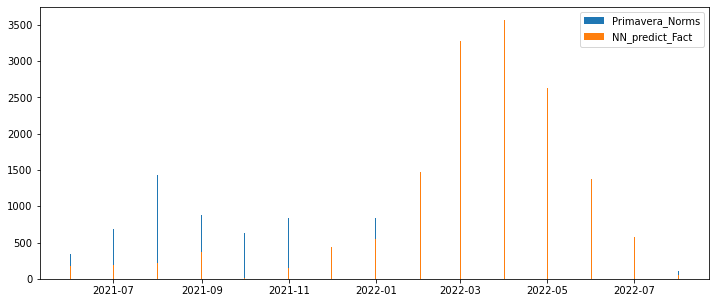

In [30]:
def plot(i,proj):
#     i = 30
#     proj = 23
    plt.bar(result.loc[(result.res_id==i) & (result.proj_id == proj),'dt'], result.loc[(result.res_id == i) & (result.proj_id==proj), 'Fact'],label = 'Primavera_Norms')
    plt.bar(result.loc[(result.res_id==i) & (result.proj_id == proj),'dt'], result.loc[(result.res_id == i) & (result.proj_id==proj),'Predict_NN'], label = 'NN_predict_Fact')
    plt.legend(loc='best')
plot(30,17)


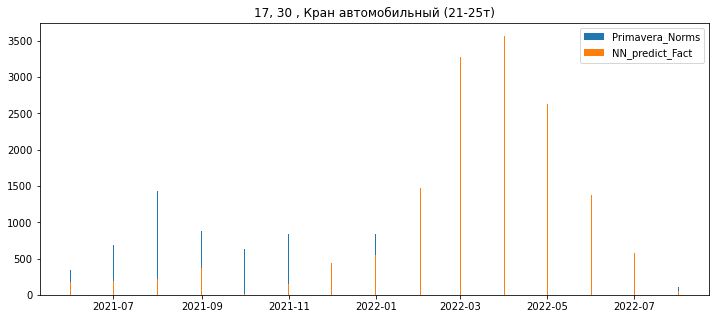

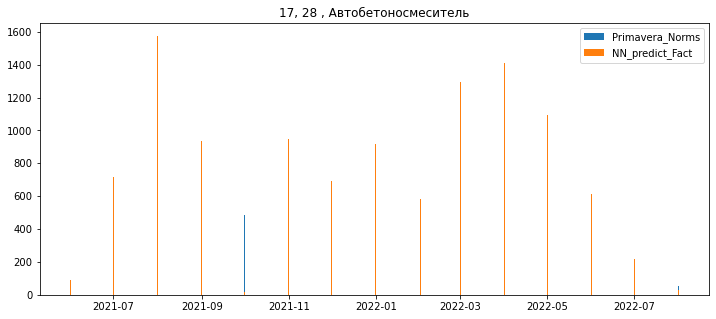

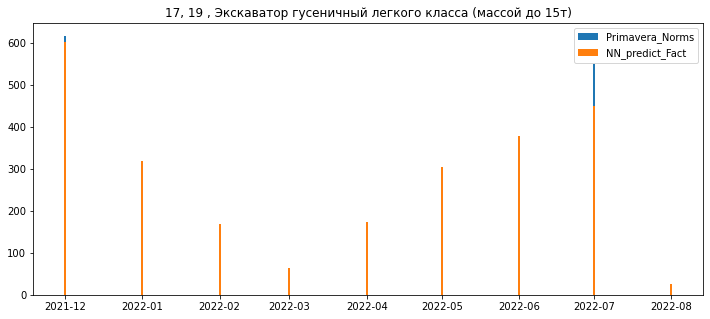

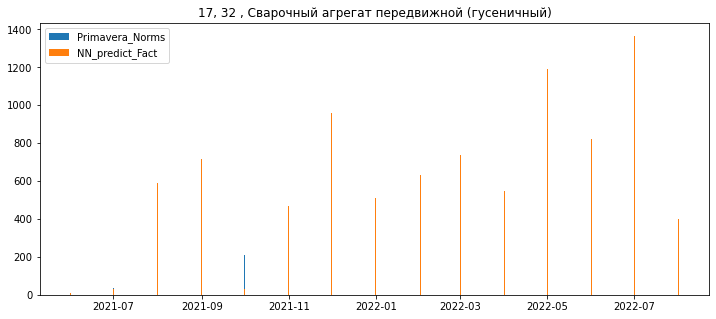

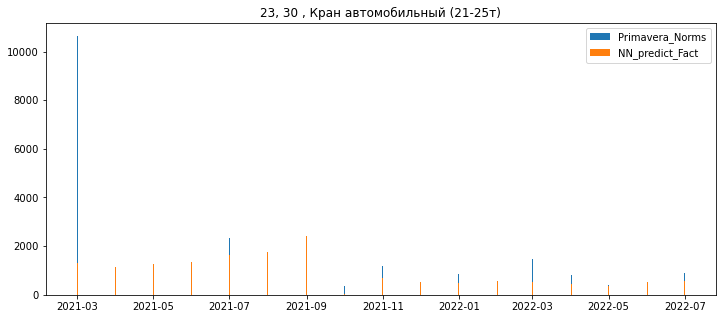

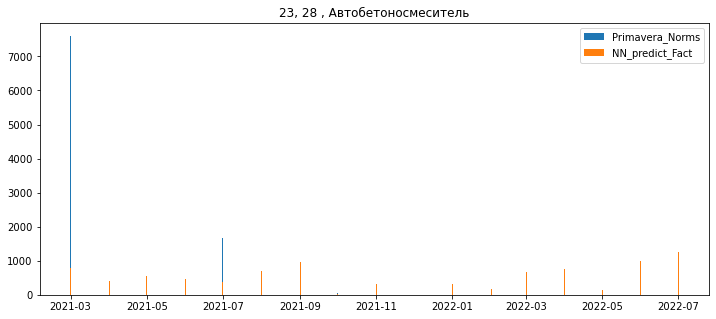

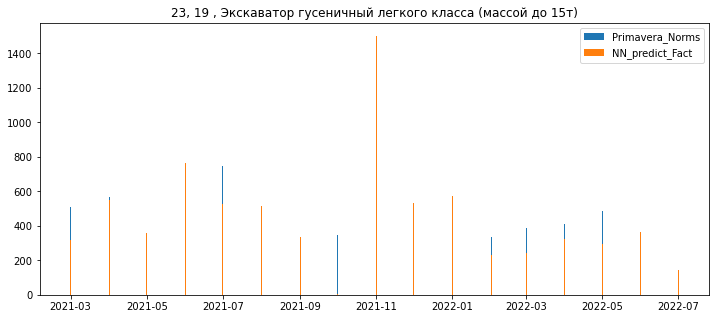

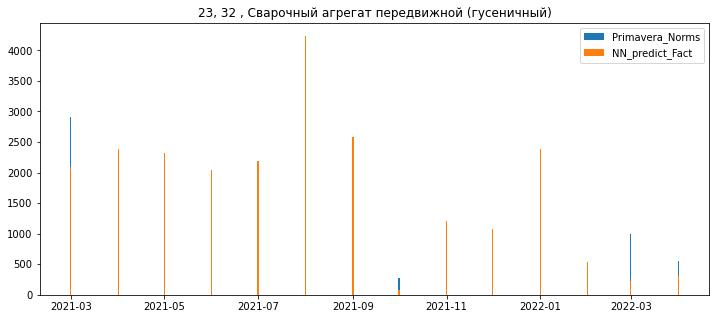

In [31]:
# to be used for publication
id = [30, 28,19,32 ] #,112,48
for p in [17,23]:
    for l in id:
        plt.title(f'{p}, {l} , {mech_res_dict_ids.get(l)}')
        plot(l,p)
        plt.show()
    

### Выгружаем bottom_left (создаем PO_name)

In [32]:
# PO создаем
result['PO_id'] = np.nonzero(result.iloc[:,3:-11].values)[1]
norms_ids_dict = np.load('./data/Needed_materials/Norms_ids_dict.npy', allow_pickle=True).item()
l = [ int(str(k)[2:]) if str(k)[2:].isnumeric() else str(k)[2:] for k in norms_ids_dict.keys()]
norms_dict = dict(zip(l,norms_ids_dict.values()))
result['PO_name'] = result.PO_id.map(norms_dict)

In [33]:
# объединяем и выгружаем
result_new = result.loc[:,['proj_id','project_name','res_id','resource_name', 'contr_id', 'contractor_name','PO_id','PO_name','dt','Fact','Predict_NN']]

result_new.columns = ['project_id','project_name','resource_id','resource_name','contractor_id','contractor_name','PO_id','PO_name','dt','Fact','Predict_NN']
result_new.to_excel('./data/4_to_export/filled_template_bottom_left.xlsx', index=False,sheet_name = 'bottom_left')
result_new             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,PO_id,PO_name,dt,Fact,Predict_NN
0,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",4,Устройство ливневой канализации,2021-03-01,31.824629,63.597397
1,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",8,Прочее (Демонтажные работы - труба),2021-03-01,1054.080000,248.919220
2,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",11,Устройство свайного основания (буронабивные),2021-03-01,10641.414402,1309.890747
3,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",13,Устройство основания (песчаное),2021-03-01,96.920000,30.919445
4,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",14,Бетонирование (бетонная подготовка),2021-03-01,30.976935,1.517365
...,...,...,...,...,...,...,...,...,...,...,...
1078,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",71,"Монтаж кабельных полок, стоек",2022-08-01,1.666820,0.482523
1079,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",84,Монтаж дорожных ж/б плит,2022-08-01,1.243416,5.875149
1080,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",85,Монтаж сборных ЖБК (бордюр),2022-08-01,0.104342,0.199209
1081,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",280,Предварительные гидравлические испытания КУ_узел,2022-08-01,0.102080,0.032096


In [34]:
# сохраняем result так как он понадобится для графика Bottom_right
result.to_excel('./data/4_to_export/result.xlsx', index=False)

## Top_right

In [278]:
result['coef_1_org'] = 0.25
result['coef_2_repair'] = 0.25
result['coef_3_mat'] = 0.25
result['coef_4_manag'] = 0.25

In [279]:
# объединяем и выгружаем
result_new = result.loc[:,['proj_id','project_name','res_id',
                           'resource_name', 'contr_id', 'contractor_name',
                           'PO_id','PO_name','dt',
                           'coef_1_org', 'coef_2_repair',
                           'coef_3_mat', 'coef_4_manag'] ]

result_new.columns = ['project_id','project_name','resource_id',
                      'resource_name','contractor_id','contractor_name',
                      'PO_id','PO_name','dt',
                      'coef_1_org', 'coef_2_repair',
                           'coef_3_mat', 'coef_4_manag'] 

result_new.to_excel('./data/4_to_export/filled_template_top_right.xlsx', 
                    index=False,sheet_name = 'filled_template_top_right')
result_new             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,PO_id,PO_name,dt,coef_1_org,coef_2_repair,coef_3_mat,coef_4_manag
0,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",4,Устройство ливневой канализации,2021-03-01,0.25,0.25,0.25,0.25
1,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",8,Прочее (Демонтажные работы - труба),2021-03-01,0.25,0.25,0.25,0.25
2,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",11,Устройство свайного основания (буронабивные),2021-03-01,0.25,0.25,0.25,0.25
3,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",13,Устройство основания (песчаное),2021-03-01,0.25,0.25,0.25,0.25
4,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",14,Бетонирование (бетонная подготовка),2021-03-01,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",71,"Монтаж кабельных полок, стоек",2022-08-01,0.25,0.25,0.25,0.25
1079,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",84,Монтаж дорожных ж/б плит,2022-08-01,0.25,0.25,0.25,0.25
1080,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",85,Монтаж сборных ЖБК (бордюр),2022-08-01,0.25,0.25,0.25,0.25
1081,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",280,Предварительные гидравлические испытания КУ_узел,2022-08-01,0.25,0.25,0.25,0.25


## Bottom_right

In [277]:
# загружаем result так как он понадобится для графика 
result = pd.read_excel('./data/4_to_export/result.xlsx')

In [262]:
# загружаем веса модели
net_state_dict = torch.load('./weights/log_model_huber_05_epoch_500_loss_69_mae_547.pt')
net.load_state_dict(net_state_dict)


<All keys matched successfully>

In [263]:
result['coef_1_activity'] = abs(result.apply(lambda x: net_state_dict['activity_dense.weight'][x.res_id,x.PO_id].numpy(),axis =1))

In [264]:
result['coef_2_month'] = abs(result.apply(lambda x: net_state_dict['month_dense.weight'][0,int(x.month)-1].numpy() * net_state_dict['year_dense.weight'][0,int(x.year)].numpy()  ,axis =1 ))

In [265]:
result['coef_3_pos'] = abs(result.contr_id.apply(lambda x: net_state_dict['contractor_dense.weight'][0,x].numpy() ))

In [275]:
#  даобавить коэф. ремонтируемых машин.


### работа над коэффициентом ремонта - загружаем ремонтные машины, находим соотношение в ремонте- в работе обновляем coef_4

In [179]:
rem = pd.read_excel('./data/1_external/undentified/RENAME_IDINTROBJ.xlsx', dtype=datetime)

C:\Users\msi\AppData\Local\Temp\ipykernel_1568\1265679017.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  rem = pd.read_excel('./data/1_external/undentified/RENAME_IDINTROBJ.xlsx', dtype=datetime)


In [115]:
pd.unique(rem.IDINTROBJ)

array(['КС-2 Олекминская Сила Сибири Этап 5.2',
       'КС-7 Сивакинская Сила Сибири Этап 5.7'], dtype=object)

In [ ]:
# выбираем только 'КС-2 Олекминская Сила Сибири Этап 5.2'
rem = rem.loc[rem.IDINTROBJ.str.contains('КС-2')]

In [180]:
# собираем все уникальные классы машин
a = pd.unique(rem.TechClass)  
uniq_tech_dict = dict(zip(a,range(len(a))) )
uniq_tech_dict_ids = {v:k for k,v in uniq_tech_dict.items()}
rem['TechClass_ids'] = rem.TechClass.map(uniq_tech_dict)

In [181]:
# машины, которые участвовали в первом отборе на выгрузку
#id = [30, 28,19,32 ]
list(zip(id,list(map(mech_res_dict_ids.get,id) )) )

[(30, 'Кран автомобильный (21-25т)'),
 (28, 'Автобетоносмеситель'),
 (19, 'Экскаватор гусеничный легкого класса (массой до 15т)'),
 (32, 'Сварочный агрегат передвижной (гусеничный)')]

In [226]:
#в ручную выбрали из списка совпадающие классы - technique_for_repair_count
technique_for_repair_count = [6,19,12,5]
print('id --- | --- mech_name --- | --- group_id --- |')
list(zip(id,list(map(mech_res_dict_ids.get,id) ),map(uniq_tech_dict_ids.get,technique_for_repair_count),technique_for_repair_count  ) )

id --- | --- mech_name --- | --- group_id --- |


[(30, 'Кран автомобильный (21-25т)', 'Краны', 6),
 (28, 'Автобетоносмеситель', 'Сварочная техника', 19),
 (19,
  'Экскаватор гусеничный легкого класса (массой до 15т)',
  'Спецавтотранспорт',
  12),
 (32, 'Сварочный агрегат передвижной (гусеничный)', 'Экскаваторы', 5)]

In [228]:
# совместили классы с машинами
mech_uniq_tech_matches = {30:6, 28:12, 19:5, 32:19}
mech_uniq_tech_matches = {v:k for k,v in mech_uniq_tech_matches.items()}

In [183]:
rem['dt'] = rem.ARDate.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.000'))
rem['month'] = rem.dt.dt.month
rem['year'] = rem.dt.dt.year

In [260]:
# обновляем коэффициент coef_4_repair

# создаем новый столбец в result
result['coef_4_repair'] = 0.1

technique_for_repair_count = [6,19,12,5]
# итерируемся по технике
for j in technique_for_repair_count:
    
    # итерируемся по месяцу и году, считаем машины "в работе" и НЕ "в работе" подставляем в result
    for  i in rem.loc[rem.TechClass_ids == j].groupby(['year','month']):
        #print(i[0])
        #print(i[1])
        on_duty = i[1].loc[i[1].Status.str.contains('В работе'), 'Amount'].agg(lambda x: (x.sum()+1) / x.count())
        on_repair = i[1].loc[~i[1].Status.str.contains('В работе'), 'Amount'].agg(lambda x: (x.sum()+1) / x.count())
        coef_4 = round(on_duty/on_repair,2)
        
        #print(on_duty,on_repair,coef_4)
        
        # подставляем coef_4 в result
        res_id = mech_uniq_tech_matches[j]
        result.loc[(result.res_id == res_id) & (result.year== i[0][0]-2021) & (result.month==i[0][1]),'coef_4_repair' ] = coef_4     
        #print('-'*25)

    print(f'машины id = {res_id}, name = {mech_res_dict_ids[res_id]} finished')
print('Done')

машины id = 30, name = Кран автомобильный (21-25т) finished
машины id = 32, name = Сварочный агрегат передвижной (гусеничный) finished
машины id = 28, name = Автобетоносмеситель finished
машины id = 19, name = Экскаватор гусеничный легкого класса (массой до 15т) finished
Done


In [271]:
# объединить в круговую диаграмму - все коэф. нормализируем 
result['sum_coef'] = result.apply(lambda x: x.coef_1_activity + x.coef_2_month + x.coef_3_pos + x.coef_4_repair,axis=1)

result['coef_1_activity'] = result.apply(lambda x: x.coef_1_activity/x.sum_coef, axis=1)
result['coef_2_month'] = result.apply(lambda x: x.coef_2_month/x.sum_coef, axis=1)
result['coef_3_pos'] = result.apply(lambda x: x.coef_3_pos/x.sum_coef, axis=1)
result['coef_4_repair'] = result.apply(lambda x: x.coef_4_repair/x.sum_coef, axis=1)


In [274]:
# объединяем и выгружаем
result_new = result.loc[:,['proj_id','project_name','res_id',
                           'resource_name', 'contr_id', 'contractor_name',
                           'PO_id','PO_name','dt',
                           'coef_1_activity', 'coef_2_month',
                           'coef_3_pos', 'coef_4_repair'] ]

result_new.columns = ['project_id','project_name','resource_id',
                      'resource_name','contractor_id','contractor_name',
                      'PO_id','PO_name','dt',
                      'coef_1_activity', 'coef_2_month',
                           'coef_3_pos', 'coef_4_repair'] 

result_new.to_excel('./data/4_to_export/filled_template_bottom_right.xlsx', 
                    index=False,sheet_name = 'filled_template_bottom_right')
result_new             


,project_id,project_name,resource_id,resource_name,contractor_id,contractor_name,PO_id,PO_name,dt,coef_1_activity,coef_2_month,coef_3_pos,coef_4_repair
0,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",4,Устройство ливневой канализации,2021-03-01,0.277918,0.146445,0.284644,0.290994
1,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",8,Прочее (Демонтажные работы - труба),2021-03-01,0.207742,0.160677,0.312307,0.319274
2,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",11,Устройство свайного основания (буронабивные),2021-03-01,0.314892,0.138946,0.270068,0.276093
3,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",13,Устройство основания (песчаное),2021-03-01,0.146082,0.173182,0.336613,0.344122
4,23,КС-2 Олекминская Сила Сибири Этап 5.2,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",14,Бетонирование (бетонная подготовка),2021-03-01,0.424900,0.116636,0.226704,0.231761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",71,"Монтаж кабельных полок, стоек",2022-08-01,0.226460,0.157362,0.572196,0.043982
1079,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",84,Монтаж дорожных ж/б плит,2022-08-01,0.564272,0.088641,0.322312,0.024775
1080,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",85,Монтаж сборных ЖБК (бордюр),2022-08-01,0.438130,0.114302,0.415621,0.031947
1081,17,КС-3 Амгинская Сила Сибири Этап 5.3,30,Кран автомобильный (21-25т),1,"ООО ""СГК-1""",280,Предварительные гидравлические испытания КУ_узел,2022-08-01,0.197291,0.163296,0.593773,0.045640


In [276]:
result.to_excel('./data/4_to_export/result_after_right_bottom.xlsx')

## Old data to Delete

### (old _ уже не используется) Создаем файл Excel по определенной машине (old _ уже не используется)

In [ ]:
df  = pd.read_excel('./data/1_external/Primavera_features/EXCEL/КС-3 Амгинская Сила Сибири Этап 5.3.xlsx')

In [22]:
mech_res_dict = np.load( './scripts/3_final/mech_res_dict.npy', allow_pickle=True).item()
c = pd.read_excel('./data/Needed_materials/mech_missed_ids.xlsx',usecols=[0,1],).dropna()
c = c.set_index('missed_name').id.astype( int ).to_dict()
mech_res_dict = {**c,**mech_res_dict}

In [ ]:
df['resource_id'] = df.resource_name.map(mech_res_dict)
assert sum(pd.isna(df.resource_id)) == 0, 'есть пустые машины'

In [157]:
feature_contractor_dict = np.load('./scripts/3_final/all_contractors.npy', allow_pickle=True).item()
df['contractor_id'] = df.contractor_name.map(feature_contractor_dict)
assert sum(pd.isna(df.contractor_id)) == 0, 'есть пустые контракторы'

AttributeError: 'DataFrame' object has no attribute 'contractor_name'

In [59]:
norms_ids_dict = np.load('./data/Needed_materials/Norms_ids_dict.npy', allow_pickle=True).item()
df['PO_name'] = df.PO_id.map(norms_ids_dict)
assert sum(pd.isna(df.PO_name)) == 0, 'есть пустые PO_name'

In [79]:
from datetime import datetime 
df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

In [ ]:
for i,name in enumerate(['КС-3 Амгинская Сила Сибири Этап 5.3.xlsx','КС-2 Олекминская Сила Сибири Этап 5.2.xlsx'])
df  = pd.read_excel(f'./data/1_external/Primavera_features/EXCEL/{name}')

df['resource_id'] = df.resource_name.map(mech_res_dict)
assert sum(pd.isna(df.resource_id)) == 0, 'есть пустые машины'

df['contractor_id'] = df.contractor_name.map(feature_contractor_dict)
assert sum(pd.isna(df.contractor_id)) == 0, 'есть пустые контракторы'

df['PO_name'] = df.PO_id.map(norms_ids_dict)
assert sum(pd.isna(df.PO_name)) == 0, 'есть пустые PO_name'

df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

df_new = df.loc[:,['id_project','project_name','id_resource','resource_name', 'contractor_id', 'contractor_name','PO_id','PO_name','dt','act_reg_qty'  ]]
df_new['fact'] = 0
df_new['predict'] = 0
df_new.columns = ['project_id','project_name','resource_id','resource_name','Contractor_id','Contractor_name','PO_id','PO_name(Work_name)','dt','Plan','Fact','Predict_NN']
df_new.to_excel('./data/4_to_export/filled_template.xlsx', index=False)



In [ ]:
# создаем новые поля coef_1_activity, coef_2_month , coef_3_position
result['']

In [269]:
np.nonzero(df_new.iloc[-1,3:-11].values)

(array([11, 21], dtype=int64),)

In [253]:
# start_pos = 3
# end_pos = 11
# l = pd.DataFrame([df_new.iloc[0,:start_pos] for _ in range(len(a))]).reset_index(drop= True)
# k = pd.DataFrame([df_new.iloc[0,-end_pos:] for _ in range(len(a))]).reset_index(drop= True)

# a = df_new.iloc[0]
# a = np.nonzero(a[3:-11].values)[0]
# b = np.zeros((len(a),373))

# for i,j in enumerate(a):
#     b[i,j] = df_new.iloc[0][start_pos+j]

# res = pd.concat([ l,pd.DataFrame(b),k],axis=1,ignore_index=True )


In [196]:
for i,j in enumerate(a):
    b[i,j] = df_new.iloc[0][start_pos+j]
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [252]:

res = pd.concat([ l,pd.DataFrame(b),k],axis=1,ignore_index=True, )

In [ ]:
pd.DataFrame()

In [178]:
df_new.append(df_new.iloc[0])

C:\Users\msi\AppData\Local\Temp\ipykernel_10124\896108613.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new.append(df_new.iloc[0])


,Unnamed: 0,proj_id,contr_id,0,1,2,3,4,5,6,...,year,res_id,target,project_name,resource_name,contractor_name,Plan,Fact,dt,Predict_NN
20,20,23,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,0,28,1221.00,КС-2 Олекминская Сила Сибири Этап 5.2,Автобетоносмеситель,"ООО ""СГК-1""",8131.646914,1221.00,2021-03-01,1224.605469
24,24,23,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,0,19,620.00,КС-2 Олекминская Сила Сибири Этап 5.2,Экскаватор гусеничный легкого класса (массой д...,"ООО ""СГК-1""",649.886509,620.00,2021-03-01,630.373718
23,23,23,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,0,32,3366.01,КС-2 Олекминская Сила Сибири Этап 5.2,Сварочный агрегат передвижной (гусеничный),"ООО ""СГК-1""",4045.658071,3366.01,2021-03-01,3485.977051
22,22,23,1,0.0,0.0,0.0,0.0,31.824629,0,0,...,0,30,2612.04,КС-2 Олекминская Сила Сибири Этап 5.2,Кран автомобильный (21-25т),"ООО ""СГК-1""",15064.347697,2612.04,2021-03-01,2743.156494
42,42,23,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,0,28,1186.02,КС-2 Олекминская Сила Сибири Этап 5.2,Автобетоносмеситель,"ООО ""СГК-1""",402.503894,1186.02,2021-04-01,786.559448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,446,17,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,1,30,7496.00,КС-3 Амгинская Сила Сибири Этап 5.3,Кран автомобильный (21-25т),"ООО ""СГК-1""",173.604735,7496.00,2022-08-01,104.443245
448,448,17,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,1,32,809.10,КС-3 Амгинская Сила Сибири Этап 5.3,Сварочный агрегат передвижной (гусеничный),"ООО ""СГК-1""",101.826081,809.10,2022-08-01,401.715057
457,457,17,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,1,19,485.00,КС-3 Амгинская Сила Сибири Этап 5.3,Экскаватор гусеничный легкого класса (массой д...,"ООО ""СГК-1""",17.438728,485.00,2022-08-01,24.923759
459,459,17,1,0.0,0.0,0.0,0.0,0.000000,0,0,...,1,28,1385.00,КС-3 Амгинская Сила Сибири Этап 5.3,Автобетоносмеситель,"ООО ""СГК-1""",59.481421,1385.00,2022-08-01,26.630539


In [172]:
start_pos = 3

pd.concat([df_new.iloc[0].T,df_new.iloc[0].T],axis=1,ignore_index=True)


,0,1
Unnamed: 0,20,20
proj_id,23,23
contr_id,1,1
0,0.0,0.0
1,0.0,0.0
...,...,...
contractor_name,"ООО ""СГК-1""","ООО ""СГК-1"""
Plan,8131.646914,8131.646914
Fact,1221.0,1221.0
dt,2021-03-01 00:00:00,2021-03-01 00:00:00


In [ ]:
for i in a[3:-11] :
    if i >0:
        
pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],
...           ignore_index=True)

In [139]:
df_new.append()

month                                                  2
year                                                   0
res_id                                                28
target                                            1221.0
project_name       КС-2 Олекминская Сила Сибири Этап 5.2
resource_name                        Автобетоносмеситель
contractor_name                              ООО "СГК-1"
Plan                                         8131.646914
Fact                                              1221.0
dt                                   2021-03-01 00:00:00
Predict_NN                                   1224.605469
Name: 20, dtype: object

In [73]:
pd.DataFrame(result)

,res_id,res_name,model_MAE,count
0,51,Автобетоноподатчик,19.117668,1
1,179,Кран автомобильный (50-99т),710.102309,17
2,42,Трубоукладчик тяжелого класса (81т и более),1986.646080,2
3,88,Самосвал (21-25т),210.249727,1
4,12,Автогидроподъемник (до 22м),598.966580,16
5,9,Тягач седельный,1019.795113,7
6,76,Бульдозер тяжелого класса (массой свыше 35т),628.493862,7
7,176,Сварочный агрегат передвижной (колесный),968.491744,17
8,175,Кран автомобильный (26-49т),395.973880,17
9,112,Экскаватор гусеничный среднего класса с гидрол...,468.880323,14


In [58]:
feature_contractor_dict = np.load('./scripts/3_final/all_contractors.npy', allow_pickle=True).item()
df['contractor_id'] = df.contractor_name.map(feature_contractor_dict)
assert sum(pd.isna(df.contractor_id)) == 0, 'есть пустые контракторы'

In [59]:
norms_ids_dict = np.load('./data/Needed_materials/Norms_ids_dict.npy', allow_pickle=True).item()
df['PO_name'] = df.PO_id.map(norms_ids_dict)
assert sum(pd.isna(df.PO_name)) == 0, 'есть пустые PO_name'

In [79]:
from datetime import datetime 
df['dt'] = df.dt.apply( lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

In [ ]:
# достаем данные по технике 39629 Кран автомобильный (21-25т)


### читаем файл по определенной машине

In [7]:
df = pd.read_excel('data/4_to_export/example_stand_for_GSP.xlsx')

In [8]:
df.head()

,PO_id,dt,resource_name,act_reg_qty,mat_res_name,mat_res_qt,Norm_coef,NN_coef,act_reg_qty_NN,время простоя
0,PO2,2021-04-01,Экскаватор гусеничный тяжелого класса (массой ...,520.950208,Метр кубический,34500.0,66.225139,35.0,985.714286,464.764078
1,PO2,2021-05-01,Экскаватор гусеничный тяжелого класса (массой ...,230.229791,Метр кубический,15247.0,66.225139,NaN,NaN,NaN
2,PO3,2021-04-01,Экскаватор гусеничный тяжелого класса (массой ...,534.998844,Метр кубический,50000.0,93.458146,NaN,NaN,NaN
3,PO3,2021-05-01,Экскаватор гусеничный тяжелого класса (массой ...,75.434836,Метр кубический,7050.0,93.458147,NaN,NaN,NaN
4,PO3,2021-06-01,Экскаватор гусеничный тяжелого класса (массой ...,129.876320,Метр кубический,12138.0,93.458145,NaN,NaN,NaN


In [ ]:
# преобразование времени
df['dt'] = df['dt'].apply(lambda t: datetime.strptime(t,'%Y-%m-%d')) 
df['month'] = df.dt.apply( lambda x: datetime.strftime(x,'%m' ) )
df['year'] = df.dt.apply( lambda x: datetime.strftime(x,'%Y' ) )


In [ ]:
# добавялем коэф из нейросети
## 49 - это код ресурса! 
df['NN_coef'] = df.PO_id.apply(lambda x: net_state_dict['activity_dense.weight'][49,int(x[2:])].numpy() )

df['NN_coef_month'] = df.month.apply(lambda x: net_state_dict['month_dense.weight'][0,int(x)-1].numpy() )

df['NN_coef_year'] = df.year.apply(lambda x: net_state_dict['year_dense.weight'][0,int(x)-2021].numpy() )

df['NN_coef_year_bias'] = net_state_dict['year_dense.bias'][0].numpy() 

df['NN_coef_contr'] = net_state_dict['contractor_dense.weight'][0,1].numpy()

In [ ]:
# сохраняемся
df.to_excel('../../19.work_cs/1. Effectivness/model/example_stand_for_GSP_processed.xlsx')

### Группировка и графики

In [ ]:
# прочитали
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
# сгруппировали
new_df = df.groupby(by=['PO_id','year_month'])[['act_reg_qty','act_reg_qty_NN','время простоя']].sum()
new_df.head()

In [ ]:
# сохранили
new_df.reset_index(inplace=True)
new_df.to_excel('../../19.work_cs/1. Effectivness/model/example_stand_for_GSP_processed_PO.xlsx')

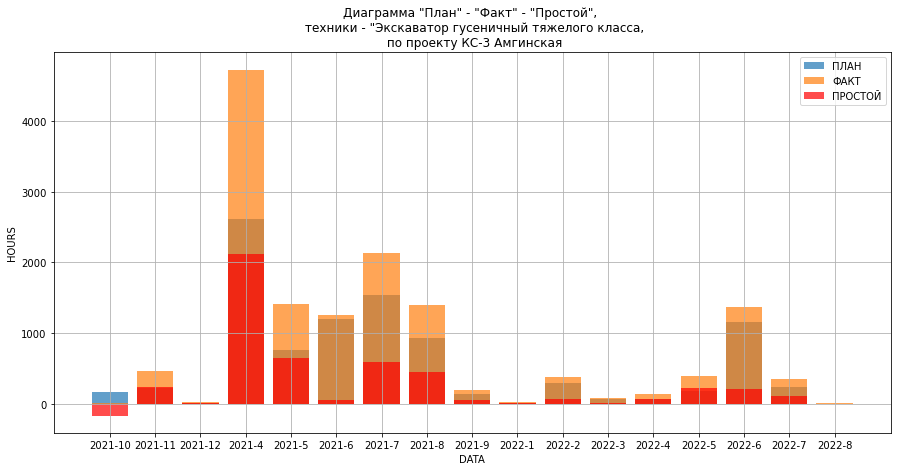

In [174]:
# Отрисовка
plt.figure(figsize=(15,7))
plt.bar(new_df.year_month,height=new_df.act_reg_qty,label='ПЛАН',alpha=0.7)
plt.bar(new_df.year_month,height=new_df.act_reg_qty_NN,label='ФАКТ',alpha=0.7)
plt.bar(new_df.year_month,height=new_df['время простоя'],label='ПРОСТОЙ',color ='red',alpha=0.7)

plt.legend(loc='best')
plt.xlabel('DATA')
plt.ylabel('HOURS')
plt.title('Диаграмма "План" - "Факт" - "Простой", \n техники - "Экскаватор гусеничный тяжелого класса,\n по проекту КС-3 Амгинская')
plt.grid();

In [5]:
df_pred = pd.read_excel('./data/4_to_export/predict_template_top_left/predict_ks2.xlsx')
df_pred.head()

,Unnamed: 0,date,project,predict,resource,resource_id
0,142,2021-11-01,КС-2 Олекминская Сила Сибири Этап 5.2,0.00000,Экскаватор-планировщик,235
1,143,2022-05-01,КС-2 Олекминская Сила Сибири Этап 5.2,0.00000,Экскаватор-планировщик,235
2,144,2022-06-01,КС-2 Олекминская Сила Сибири Этап 5.2,0.00000,Экскаватор-планировщик,235
3,145,2022-07-01,КС-2 Олекминская Сила Сибири Этап 5.2,4.75384,Экскаватор-планировщик,235
4,146,2022-08-01,КС-2 Олекминская Сила Сибири Этап 5.2,99.84922,Экскаватор-планировщик,235


In [23]:
ids = [30, 28,19,32 ] 

In [31]:
df_pred['res_id'] = df_pred.resource.map(mech_res_dict)
[i for i in ids if i in pd.unique(df_pred.res_id)]

[30, 19, 32]

In [9]:
df_pred['year'] = df_pred.date.dt.year
df_pred['month'] = df_pred.date.dt.month
df_pred.groupby(['year','month']).resource_id.value_counts()

year  month  resource_id
2021  3      2              1
             5              1
             14             1
             19             1
             29             1
                           ..
2022  8      111            1
             112            1
             115            1
             234            1
             235            1
Name: resource_id, Length: 280, dtype: int64

In [130]:
# from glob import glob
# import re

# feat = np.zeros([1,378])


# for name in glob('./data/4_to_export/predict_template_top_left/*.xlsx'):
#     print(name)
#     l = name.split('\\')[-1]
    
#     if not re.findall(r'КС', l ): 
#         print('pass')
#         continue
#     else: 
#         df = pd.read_excel(name,
#                usecols= ['PO_id','dt', 'resource_name', 'id_resource', 'remain_qty'])
        
        
#         a = np.zeros((len(df),378))

#         # КС-2 = 23 , КС-3 = 17
#         if re.findall(r'КС_2', l ): contr_id = 23
#         else: contr_id = 17
#         a[:,0] = contr_id

#         #contr_id = 1 (СГК)
#         a[:,1] = 1 
        
#         # res_id
#         df['res_id'] = df.resource_name.map(mech_res_dict)
#         assert sum(pd.isna(df.res_id)) == 0, 'есть пустые машины'

#         # month year
#         from datetime import datetime 
#         df['month'] = df.dt.dt.month
#         df['year'] = df.dt.dt.year - 2021
        
#         for j,i in enumerate(df.groupby(['res_id','year','month','PO_id'])):
#             #res_id
#             a[j,-1] = i[0][0]
#             #year
#             a[j,-2] = i[0][1]
#             #month
#             a[j,-3] = i[0][2]
            
#             # PO number
#             po_number = int( str(i[0][-1])[2:] )
#             a[j,po_number+1] = i[1].remain_qty.sum()

#         print(j)
#         a = a[:j]
#         print('Done. a shape = ', a.shape )    
        
#         feat = np.concatenate((feat,a))

# feat = feat[1:]